# Описание 

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

Цель
Предсказать вероятность покупки в течение 90 дней

Задачи
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

В качестве метрики качества использовать ROC _AUC

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik import report

# Загрузка данныx


In [3]:
tr = pd.read_csv('/Users/nbasina/Desktop/yandexp/marketing/apparel-target_binary.csv')
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


В данных нет пропусков, значения числовые,49849 строк. 
Необходимо проверить на уникальность id и бинарность значения в признаке target

In [4]:
pr = pd.read_csv('/Users/nbasina/Desktop/yandexp/marketing/apparel-purchases.csv')
pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


История покупок, пропусков нет

- client_id идентификатор пользователя - проверить на уникальность, сверить наличие id, которых нет в таргете 
- quantity количество товаров в заказе -  проверить аномальные значения 
- price цена товара - проверить аномальные значения 
- category_ids вложенные категории, к которым отнсится товар - выделить основную категорию 
- date дата покупки  проверить аномальные значения  
- message_id идентификатор сообщения из рассылки - сверить наличие id, которых нет в рассылках

Весь датасет проверить 
- на дубликаты


In [5]:
ms = pd.read_csv('/Users/nbasina/Desktop/yandexp/marketing/apparel-messages.csv')
ms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


bulk_campaign_id идентификатор рекламной кампании 
client_id идентификатор пользователя - проверить что нет id, которых нет в таргете
message_id идентификатор сообщений 
event тип действия - оставить только важные действия
channel канал рассылки 
date дата рассылки  - проверить на аномалии 
created_at точное время создания сообщения - проверить на аномалии 

Проверить на полные дубликаты 


In [6]:
daily_event = pd.read_csv('/Users/nbasina/Desktop/yandexp/marketing/full_campaign_daily_event.csv')
daily_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu


Агрегация общей базы рассылок по дням и типам событий
в таблице нет пропусков 


- date дата проверить на аномалии 
- bulk_campaign_id идентификатор рассылки
- count_event* общее количество каждого события event
- nunique_event* количество уникальных client_id в каждом событии

In [7]:

daily_channel = pd.read_csv('/Users/nbasina/Desktop/yandexp/marketing/full_campaign_daily_event_channel.csv')
daily_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

Агрегация по дням с учетом событий и каналов рассылки
- date дата
- bulk_campaign_id идентификатор рассылки
- count_event*_channel* общее количество каждого события по каналам
- nunique_event*_channel* количество уникальных client_id по событиям и каналам

# Предобработка данных

## Таргет

In [8]:
display(tr) 


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
...,...,...
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0


In [9]:
print(tr.duplicated().sum())
print(tr['target'].value_counts())

0
target
0    48888
1      961
Name: count, dtype: int64


При обучении будет присутствовать дисбаланс классов

## История заказов

In [10]:
display(pr)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


In [11]:
pr.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459514e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [12]:
print(pr['date'].min())
print(pr['date'].max())

2022-05-16
2024-02-16


In [13]:
print(pr.duplicated().sum())

73020


In [14]:
pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [15]:
pr['category_ids']
import ast
pr['category_ids'] = pr['category_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
pr['category_ids'] = pr['category_ids'].apply(lambda x: x if len(x) == 4 else (x + [None] * 4)[:4])
# Разделяем категории на отдельные столбцы
pr[['category_1', 'category_2', 'category_3', 'category_4']] = pd.DataFrame(pr['category_ids'].tolist(), index=pr.index)

# Проверим результат
display(pr.head())


,client_id,quantity,price,category_ids,date,message_id,category_1,category_2,category_3,category_4
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413


In [16]:
# Группировка по 'category_3' и агрегация значений 'category_4' в множества
category_mapping = pr.groupby('category_3')['category_4'].agg(set)


unique_check = True
seen_categories = set()

for categories in category_mapping:
    if seen_categories & categories:  
        unique_check = False
        break
    seen_categories.update(categories)

if unique_check:
    print("Значения в 'category_4' уникальны для каждого значения в 'category_3'.")
else:
    print("Встречаются одинаковые значения 'category_4' при различных 'category_3'.")

Встречаются одинаковые значения 'category_4' при различных 'category_3'.


In [17]:
# Группировка по 'category_2' и агрегация значений 'category_3' в множества
category_mapping = pr.groupby('category_2')['category_3'].agg(set)


unique_check = True
seen_categories = set()

for categories in category_mapping:
    if seen_categories & categories:  
        unique_check = False
        break
    seen_categories.update(categories)

if unique_check:
    print("Значения в 'category_3' уникальны для каждого значения в 'category_2'.")
else:
    print("Встречаются одинаковые значения 'category_3' при различных 'category_2'.")

Встречаются одинаковые значения 'category_3' при различных 'category_2'.


In [18]:
# Группировка по 'category_1' и агрегация значений 'category_2' в множества
category_mapping = pr.groupby('category_1')['category_2'].agg(set)


unique_check = True
seen_categories = set()

for categories in category_mapping:
    if seen_categories & categories:  
        unique_check = False
        break
    seen_categories.update(categories)

if unique_check:
    print("Значения в 'category_2' уникальны для каждого значения в 'category_1'.")
else:
    print("Встречаются одинаковые значения 'category_2' при различных 'category_1'.")

Значения в 'category_2' уникальны для каждого значения в 'category_1'.


В основном в заказе по 1 товару, самая минимальная стоимость товара 1 р, это может быть ошибкой в данных или багом на сайте, но также может быть и реальным товаром со скидкой. Так что такие данные будем оставлять для работы. Самый дорогой заказ также не вызывает подозрений, скорее всего это упаковка из 30 ед какого-то продукта


Даты покупок лежат в реалистичном диапозоне

В данных присутвует 73 дубликатов, но это так же могут быть заказы сделанные пользователями в один день, так как у нас нет возможность проверить время заказа, мы не можем счиать это полными дублями. 

При проверки на уникальность значений подкатегорий было обнаружено, что категории 3 и 4 не уникальны и могут быть привязаны к нескольким родительским категориям, в то время как категория 2 уникальна относительно 1. (Для обучения оставим только признаки 1 и второй категории)

In [19]:
pr = pr.drop(columns=['category_ids','category_3','category_4'],axis =1)
pr.head()

,client_id,quantity,price,date,message_id,category_1,category_2
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,28
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,28
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,28
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,28
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,28


In [20]:
pr[['c_id', 'b_id', 'm_id']] = pr['message_id'].str.split('-', expand=True)
display(pr.head())
pr['client_id'] = pr['client_id'].astype(str).str.strip()
pr['c_id'] = pr['c_id'].astype(str).str.strip()

count_rows = (pr['client_id'] != pr['c_id']).sum()

print(count_rows)


,client_id,quantity,price,date,message_id,category_1,category_2,c_id,b_id,m_id
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,1515915625468169594,4301,627b661e9736d
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,1515915625468169594,4301,627b661e9736d
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,28,1515915625471138230,4437,6282242f27843
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,28,1515915625471138230,4437,6282242f27843
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,28,1515915625471138230,4437,6282242f27843


55683


In [21]:
pr = pr.drop(columns=['message_id','c_id'],axis =1)
#pr

In [22]:
pr['client_id'].value_counts()


client_id
1515915625853312319    346
1515915625624308268    218
1515915625607113301    210
1515915625500232103    131
1515915625470860261    131
                      ... 
1515915625559962326      1
1515915625559941251      1
1515915625468133517      1
1515915625559866916      1
1515915626010443624      1
Name: count, Length: 49849, dtype: int64

In [23]:

df = pr.groupby('client_id').agg({
    'quantity': 'count',  # Количество значений 'quantity'
    'price': ['mean', 'sum'],  # Средняя и суммарная цена
    'date': 'count',  # Количество значений 'date'
    'category_1': lambda x: x.mode()[0] if not x.mode().empty else None, # Мода для 'category_1'
    'category_2': lambda x: x.mode()[0] if not x.mode().empty else None,  # Уникальные значения в 'category_2'
    'b_id': lambda x: list(x.unique()),  # Уникальные значения в 'b_id'
    'm_id': lambda x: list(x.unique())  # Уникальные значения в 'm_id'
})





In [24]:
df.columns = ['_'.join(col) if col[1] != '' else col[0] for col in df.columns.values]
df.columns = ['count_quantity', 'mean_price','sum_price','count_date','category_1','category_2','b_id','m_id']

# Вывод результата
display(df)


,count_quantity,mean_price,sum_price,count_date,category_1,category_2,b_id,m_id
client_id,,,,,,,,
1515915625468060902,7,999.000000,6993.0,7,4,28,[4617],[6290657dac196]
1515915625468061003,7,2319.285714,16235.0,7,4,28,[9148],[63b54b04855a4]
1515915625468061099,1,299.000000,299.0,1,4,28,[4439],[62834141aa538]
1515915625468061100,2,1049.000000,2098.0,2,4,27,[14623],[65c5c55eeb9e0]
1515915625468061170,19,1768.473684,33601.0,19,4,28,"[11144, 11208, 13157]","[641ad2cda77a2, 6423f082d2fcb, 6483192913837]"
...,...,...,...,...,...,...,...,...
1515915626010261344,6,1499.000000,8994.0,6,2,18,[14648],[65cdb6d56c4c8]
1515915626010266132,2,909.000000,1818.0,2,4,27,[14623],[65c5c5acbad8c]
1515915626010439406,2,99.000000,198.0,2,4,27,[14662],[65cf3abfe4f0d]


In [25]:
tr['client_id'] = tr['client_id'].astype(str).str.strip()
df = pd.merge(df, tr, on='client_id', how='inner')
display(df)

,client_id,count_quantity,mean_price,sum_price,count_date,category_1,category_2,b_id,m_id,target
0,1515915625468060902,7,999.000000,6993.0,7,4,28,[4617],[6290657dac196],0
1,1515915625468061003,7,2319.285714,16235.0,7,4,28,[9148],[63b54b04855a4],1
2,1515915625468061099,1,299.000000,299.0,1,4,28,[4439],[62834141aa538],0
3,1515915625468061100,2,1049.000000,2098.0,2,4,27,[14623],[65c5c55eeb9e0],0
4,1515915625468061170,19,1768.473684,33601.0,19,4,28,"[11144, 11208, 13157]","[641ad2cda77a2, 6423f082d2fcb, 6483192913837]",0
...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,6,1499.000000,8994.0,6,2,18,[14648],[65cdb6d56c4c8],0
49845,1515915626010266132,2,909.000000,1818.0,2,4,27,[14623],[65c5c5acbad8c],0
49846,1515915626010439406,2,99.000000,198.0,2,4,27,[14662],[65cf3abfe4f0d],0
49847,1515915626010443527,1,1999.000000,1999.0,1,2,18,[14668],[65cf5246bd490],0


## Рассылки

In [26]:
ms.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [27]:
ms[['c_id', 'b_id', 'm_id']] = ms['message_id'].str.split('-', expand=True)
ms.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,c_id,b_id,m_id
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,1515915625626736623,4439,6283415ac07ea
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,1515915625490086521,4439,62834150016dd
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,1515915625553578558,4439,6283415b36b4f
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,1515915625553578558,4439,6283415b36b4f
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,1515915625471518311,4439,628341570c133


In [28]:
ms['bulk_campaign_id'] = ms['bulk_campaign_id'].astype(str).str.strip()
count_rows = (ms['bulk_campaign_id'] != ms['b_id']).sum()
print(count_rows)

ms['client_id'] = ms['client_id'].astype(str).str.strip()
count_rows = (ms['client_id'] != ms['c_id']).sum()
print(count_rows)



0
0


In [29]:
ms = ms.drop(columns=['message_id','c_id','b_id'],axis =1)
ms.head()

,bulk_campaign_id,client_id,event,channel,date,created_at,m_id
0,4439,1515915625626736623,open,email,2022-05-19,2022-05-19 00:14:20,6283415ac07ea
1,4439,1515915625490086521,open,email,2022-05-19,2022-05-19 00:39:34,62834150016dd
2,4439,1515915625553578558,open,email,2022-05-19,2022-05-19 00:51:49,6283415b36b4f
3,4439,1515915625553578558,click,email,2022-05-19,2022-05-19 00:52:20,6283415b36b4f
4,4439,1515915625471518311,open,email,2022-05-19,2022-05-19 00:56:52,628341570c133


In [30]:
ms.head()

,bulk_campaign_id,client_id,event,channel,date,created_at,m_id
0,4439,1515915625626736623,open,email,2022-05-19,2022-05-19 00:14:20,6283415ac07ea
1,4439,1515915625490086521,open,email,2022-05-19,2022-05-19 00:39:34,62834150016dd
2,4439,1515915625553578558,open,email,2022-05-19,2022-05-19 00:51:49,6283415b36b4f
3,4439,1515915625553578558,click,email,2022-05-19,2022-05-19 00:52:20,6283415b36b4f
4,4439,1515915625471518311,open,email,2022-05-19,2022-05-19 00:56:52,628341570c133


In [31]:
ms.describe()

,bulk_campaign_id,client_id,event,channel,date,created_at,m_id
count,12739798,12739798,12739798,12739798,12739798,12739798,12739798
unique,2709,53329,11,2,638,4103539,9061651
top,14272,1515915625516327994,send,mobile_push,2023-06-10,2023-12-29 15:20:53,6311b13a4cf78
freq,104479,3100,9058196,7512156,89661,621,1454


In [32]:
print(ms[['event']].value_counts())
print(ms[['channel']].value_counts())


event      
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64
channel    
mobile_push    7512156
email          5227642
Name: count, dtype: int64


In [33]:
# Создание списка значений, которые нужно исключить
events_to_remove = ['hard_bounce', 'soft_bounce', 'hbq_spam']


mask = ms['event'].isin(events_to_remove)
print(mask.sum())

ms = ms[~mask]
ms.info()

31309
<class 'pandas.core.frame.DataFrame'>
Index: 12708489 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  object
 1   client_id         object
 2   event             object
 3   channel           object
 4   date              object
 5   created_at        object
 6   m_id              object
dtypes: object(7)
memory usage: 775.7+ MB


In [34]:
print(ms['date'].min())
print(ms['date'].max())

print(ms['created_at'].min())
print(ms['created_at'].max())

2022-05-19
2024-02-15
2022-05-19 00:14:20
2024-02-15 23:58:40


In [35]:
ms.duplicated().sum()
ms = ms.drop_duplicates()
ms.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12660020 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  object
 1   client_id         object
 2   event             object
 3   channel           object
 4   date              object
 5   created_at        object
 6   m_id              object
dtypes: object(7)
memory usage: 772.7+ MB


Удаляем строки с событиями, которые клиент не увидел. 31к строк. 
Удалем полные дубликаты 

In [36]:
ms.head()

,bulk_campaign_id,client_id,event,channel,date,created_at,m_id
0,4439,1515915625626736623,open,email,2022-05-19,2022-05-19 00:14:20,6283415ac07ea
1,4439,1515915625490086521,open,email,2022-05-19,2022-05-19 00:39:34,62834150016dd
2,4439,1515915625553578558,open,email,2022-05-19,2022-05-19 00:51:49,6283415b36b4f
3,4439,1515915625553578558,click,email,2022-05-19,2022-05-19 00:52:20,6283415b36b4f
4,4439,1515915625471518311,open,email,2022-05-19,2022-05-19 00:56:52,628341570c133


In [37]:

ms_gr = ms.groupby('client_id').agg({
    'bulk_campaign_id': lambda x: x.mode()[0] if not x.mode().empty else None,  # 
    'event': lambda x: x.mode()[0] if not x.mode().empty else None,  #
    'channel':lambda x: x.mode()[0] if not x.mode().empty else None,
    'm_id':'count'
    
})

display(ms_gr)

,bulk_campaign_id,event,channel,m_id
client_id,,,,
1515915625468060902,4617,send,email,177
1515915625468061003,12566,send,email,165
1515915625468061099,9945,send,email,274
1515915625468061100,14280,send,mobile_push,426
1515915625468061170,11144,send,email,293
...,...,...,...,...
1515915626010183608,14648,open,mobile_push,4
1515915626010221592,14653,click,mobile_push,6
1515915626010234726,14656,send,mobile_push,1


In [38]:
ms_gr.columns = ['bulk_mode','event_unique','channel_unique','m_id_count']

# Вывод результата
display(ms_gr)

,bulk_mode,event_unique,channel_unique,m_id_count
client_id,,,,
1515915625468060902,4617,send,email,177
1515915625468061003,12566,send,email,165
1515915625468061099,9945,send,email,274
1515915625468061100,14280,send,mobile_push,426
1515915625468061170,11144,send,email,293
...,...,...,...,...
1515915626010183608,14648,open,mobile_push,4
1515915626010221592,14653,click,mobile_push,6
1515915626010234726,14656,send,mobile_push,1


In [39]:
df = df.drop(columns=['b_id','m_id'])

In [40]:
df.head()

,client_id,count_quantity,mean_price,sum_price,count_date,category_1,category_2,target
0,1515915625468060902,7,999.000000,6993.0,7,4,28,0
1,1515915625468061003,7,2319.285714,16235.0,7,4,28,1
2,1515915625468061099,1,299.000000,299.0,1,4,28,0
3,1515915625468061100,2,1049.000000,2098.0,2,4,27,0
4,1515915625468061170,19,1768.473684,33601.0,19,4,28,0


In [41]:
df= pd.merge(df, ms_gr, on='client_id', how='left')


In [42]:
df.info()
df= df.fillna ('0')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       49849 non-null  object 
 1   count_quantity  49849 non-null  int64  
 2   mean_price      49849 non-null  float64
 3   sum_price       49849 non-null  float64
 4   count_date      49849 non-null  int64  
 5   category_1      49848 non-null  object 
 6   category_2      49848 non-null  object 
 7   target          49849 non-null  int64  
 8   bulk_mode       41982 non-null  object 
 9   event_unique    41982 non-null  object 
 10  channel_unique  41982 non-null  object 
 11  m_id_count      41982 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 4.6+ MB


# Анализ данных

In [43]:
df['m_id_count']= df['m_id_count'].astype(int)
df.describe()

,count_quantity,mean_price,sum_price,count_date,target,m_id_count
count,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,4.056410,1483.415229,4840.520632,4.056410,0.019278,218.402696
std,5.521669,1388.178005,7312.865458,5.521669,0.137503,173.662080
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,699.000000,1499.000000,1.000000,0.000000,80.000000
50%,2.000000,1249.000000,2929.000000,2.000000,0.000000,199.000000
75%,5.000000,1999.000000,5677.000000,5.000000,0.000000,321.000000
max,346.000000,53499.000000,540408.000000,346.000000,1.000000,3086.000000


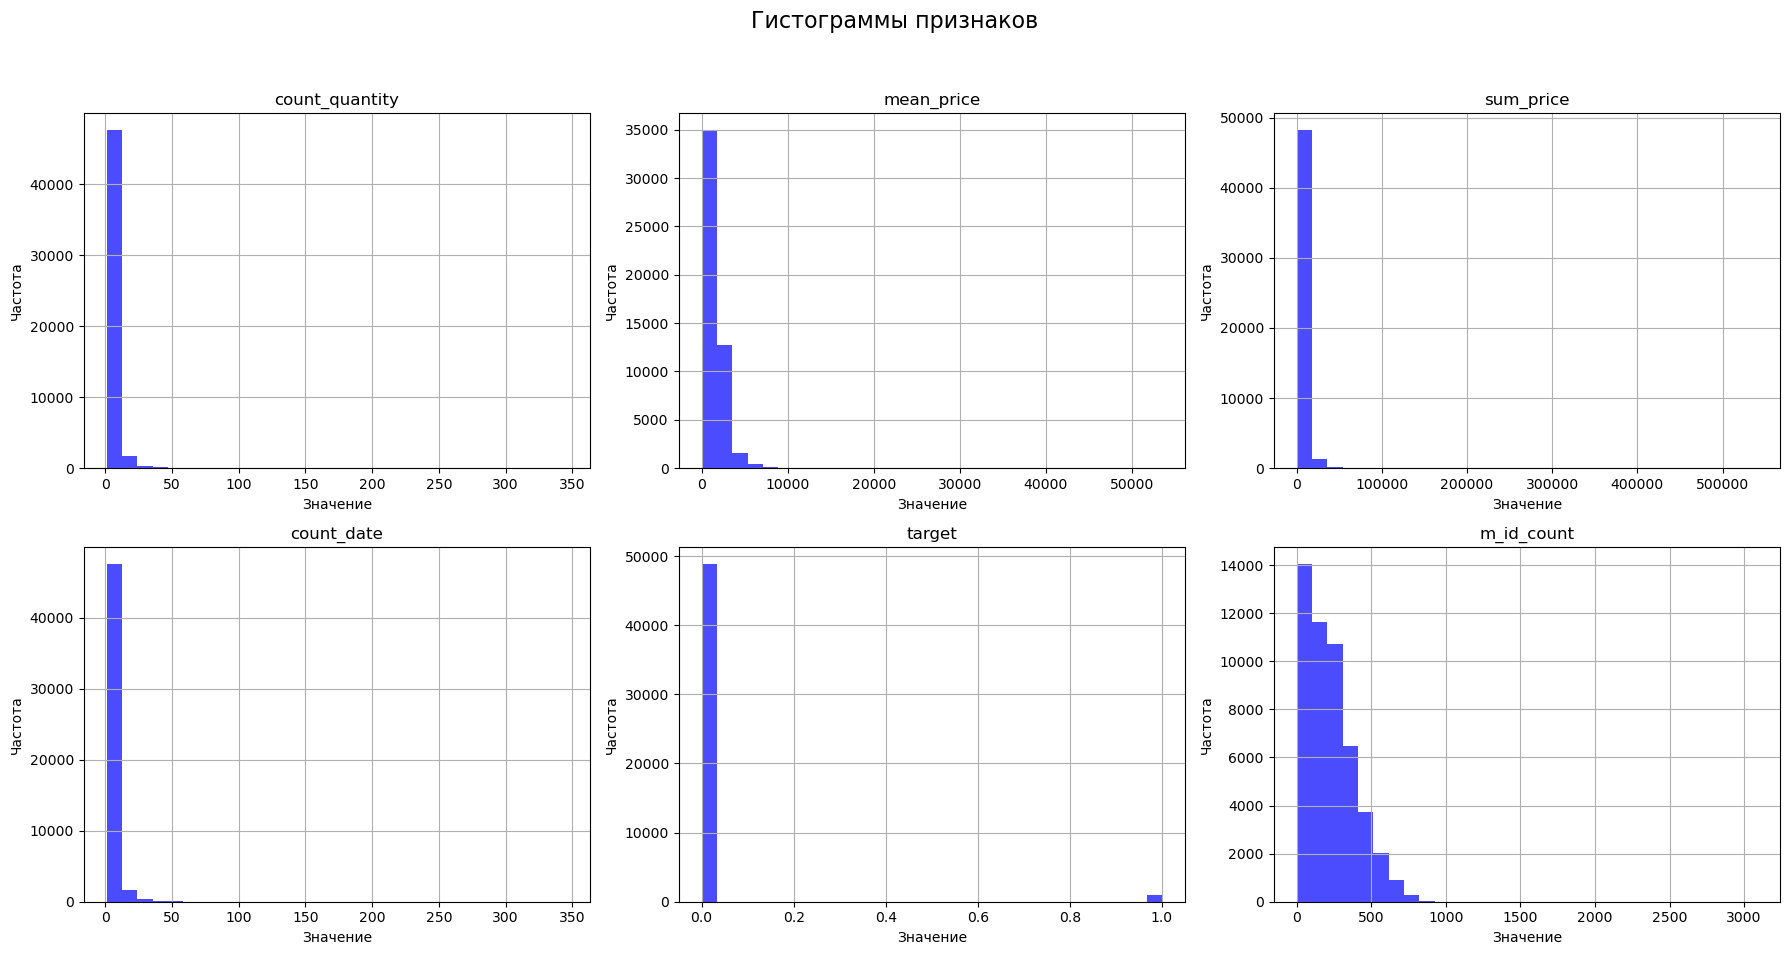

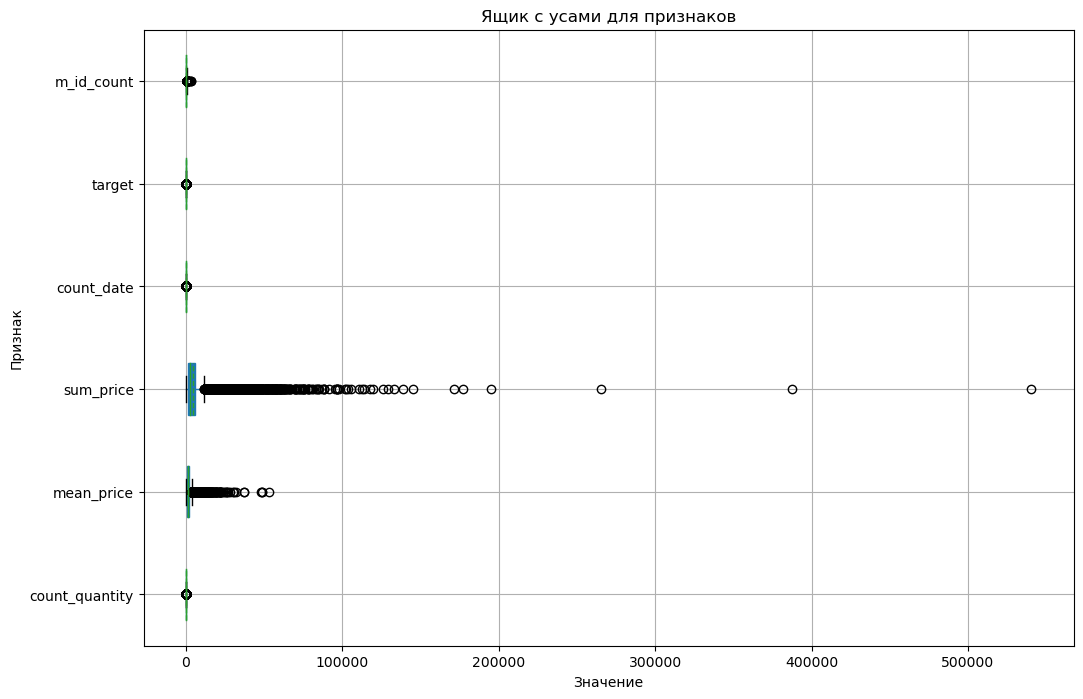

In [44]:
# Гистограммы
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Гистограммы признаков', fontsize=16)
cols = ['count_quantity', 'mean_price', 'sum_price', 'count_date', 'target', 'm_id_count']
for ax, col in zip(axes.flatten(), cols):
    df[col].hist(ax=ax, bins=30, alpha=0.7, color='blue')
    ax.set_title(col)
    ax.set_ylabel('Частота')
    ax.set_xlabel('Значение')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Ящик с усами
fig, ax = plt.subplots(figsize=(12, 8))
df.boxplot(column=cols, ax=ax, vert=False, patch_artist=True, meanline=True, showmeans=True)
ax.set_title('Ящик с усами для признаков')
ax.set_xlabel('Значение')
ax.set_ylabel('Признак')

plt.show()

In [45]:
cat_cols= ['category_1', 'category_2',  'bulk_mode','event_unique','channel_unique']

In [46]:
df.head()

,client_id,count_quantity,mean_price,sum_price,count_date,category_1,category_2,target,bulk_mode,event_unique,channel_unique,m_id_count
0,1515915625468060902,7,999.000000,6993.0,7,4,28,0,4617,send,email,177
1,1515915625468061003,7,2319.285714,16235.0,7,4,28,1,12566,send,email,165
2,1515915625468061099,1,299.000000,299.0,1,4,28,0,9945,send,email,274
3,1515915625468061100,2,1049.000000,2098.0,2,4,27,0,14280,send,mobile_push,426
4,1515915625468061170,19,1768.473684,33601.0,19,4,28,0,11144,send,email,293


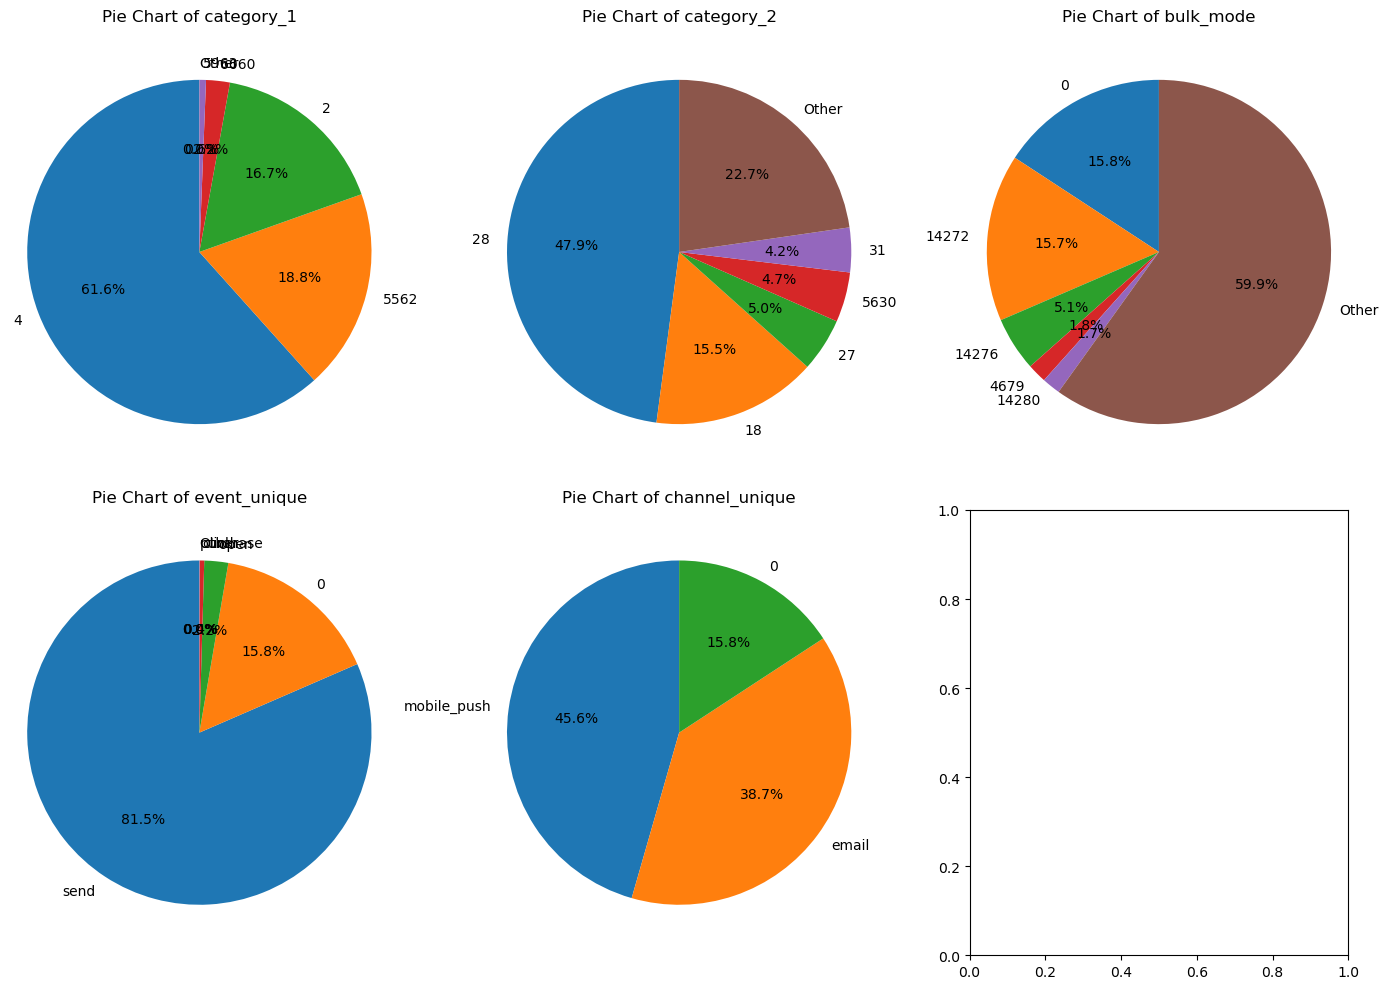

In [47]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))  
axes = axes.flatten()  #

top_n = 5  

# Итерация по категориальным признакам и построение диаграмм
for ax, feature in zip(axes, cat_cols):
    
    data = df[feature].value_counts().head(top_n)
    other_count = df[feature].value_counts().iloc[top_n:].sum()
    if other_count > 0:
        data['Other'] = other_count
    # Создание круговой диаграммы
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Pie Chart of {feature}')
    ax.axis('equal')  

plt.tight_layout()
plt.show()

In [48]:
interval_columns = ['count_quantity', 'mean_price','sum_price','count_date','m_id_count']

/Users/nbasina/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable bulk_mode is large: 1227. Are you sure this is not an interval variable? Analysis for pairs of variables including bulk_mode can be slow.
  warnings.warn(
/Users/nbasina/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable client_id is large: 49849. Are you sure this is not an interval variable? Analysis for pairs of variables including client_id can be slow.
  warnings.warn(
/Users/nbasina/anaconda3/lib/python3.11/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 61164723. Are interval variables set correctly?
  warnings.warn(


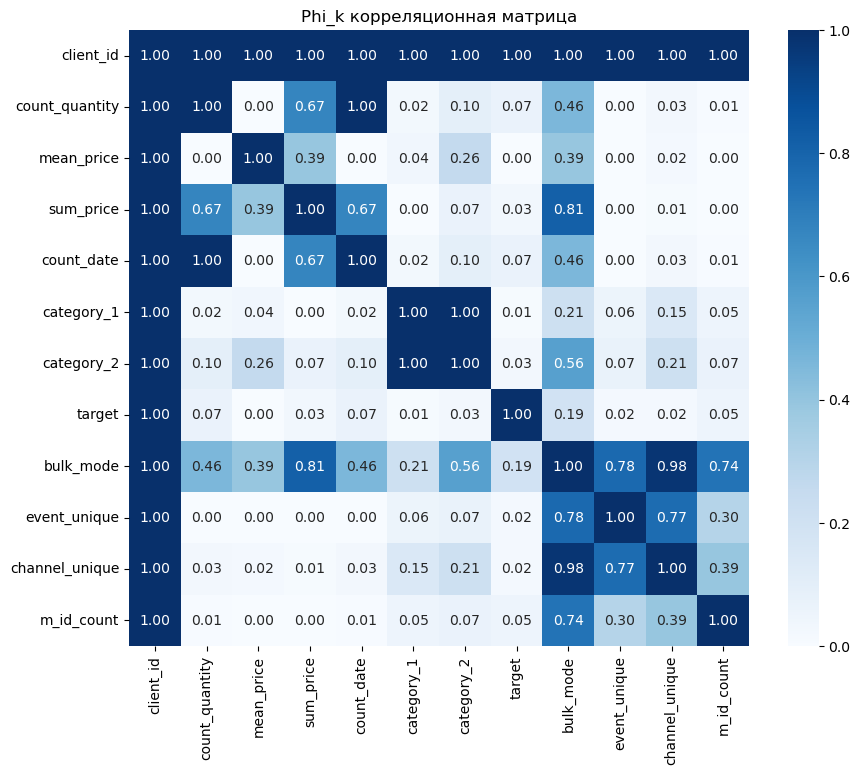

In [49]:
phik_matrix = df.phik_matrix(interval_cols=interval_columns)
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Phi_k корреляционная матрица')
plt.show()

Можно удалить категорию 1, так как она мультиколлениарна с категорией 2, также удалим номер самой популряной рассылки,
так как информация по каналу более информативна для обучения 


In [50]:
df= df.drop(columns=['category_1','bulk_mode'])
df.head()

,client_id,count_quantity,mean_price,sum_price,count_date,category_2,target,event_unique,channel_unique,m_id_count
0,1515915625468060902,7,999.000000,6993.0,7,28,0,send,email,177
1,1515915625468061003,7,2319.285714,16235.0,7,28,1,send,email,165
2,1515915625468061099,1,299.000000,299.0,1,28,0,send,email,274
3,1515915625468061100,2,1049.000000,2098.0,2,27,0,send,mobile_push,426
4,1515915625468061170,19,1768.473684,33601.0,19,28,0,send,email,293


# Обучение моделей 

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix


In [52]:
X = df.drop('target', axis=1)
y = df['target']

# Деление данных на тренировочную, валидационную и тестовую выборки
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

In [53]:
numeric_features = ['count_quantity', 'mean_price','sum_price','count_date','m_id_count']
categorical_features = ['client_id', 'category_2','event_unique','channel_unique']

In [54]:
# Создание трансформеров для предобработки
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Объединение трансформеров в один
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [55]:
# Пайплайны для различных моделей
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(verbose=0, random_state=42, auto_class_weights='Balanced'))
    ])
}

/Users/nbasina/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nbasina/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Лучшие параметры для Logistic Regression: {'classifier__C': 0.01}
ROC AUC на валидационной выборке для Logistic Regression: 0.6623220115428339


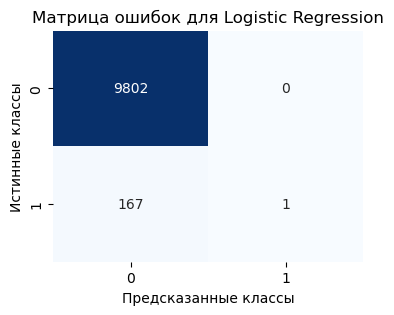

Лучшие параметры для Random Forest: {'classifier__max_depth': 30, 'classifier__n_estimators': 200}
ROC AUC на валидационной выборке для Random Forest: 0.6849306749837254


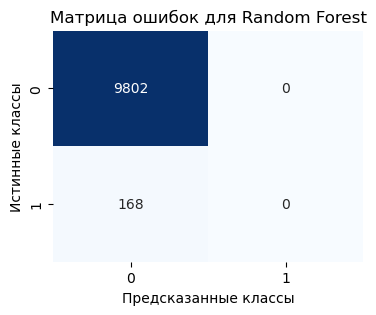

/Users/nbasina/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшие параметры для CatBoost: {'classifier__depth': 4, 'classifier__iterations': 200}
ROC AUC на валидационной выборке для CatBoost: 0.6688582747932881


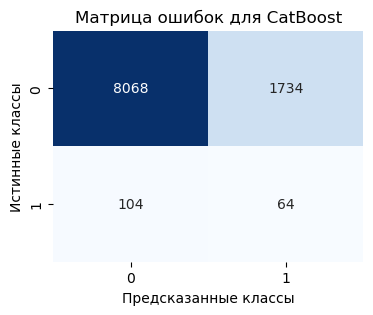

In [56]:
# Настройка гиперпараметров для каждой модели
params = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [10, 20, 30]},
    'CatBoost': {'classifier__iterations': [100, 200], 'classifier__depth': [4, 6, 10]}
}

# Обучение моделей и поиск лучших параметров
for name, pipeline in models.items():
    grid_search = GridSearchCV(pipeline, params[name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Лучшие параметры для {name}: {grid_search.best_params_}")

    # Обновляем модель с лучшими параметрами
    best_model = grid_search.best_estimator_

    # Валидация модели
    y_pred = best_model.predict(X_val)  # Используем модель с лучшими параметрами для предсказания
    y_pred_broba = best_model.predict_proba(X_val)[:, 1]
    
    roc_auc = roc_auc_score(y_val, y_pred_broba)  
    print(f"ROC AUC на валидационной выборке для {name}: {roc_auc}")

    # Создание и вывод матрицы ошибок
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Матрица ошибок для {name}')
    plt.xlabel('Предсказанные классы')
    plt.ylabel('Истинные классы')
    plt.show()

Модель Random Forest показала себя лучшей и по оценке и по кол-ву FP оценок. Для бизнеса важно минимизировать кол-во таких оценок. 

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [65]:


best_model = RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42)

best_model.fit(X_train_transformed, y_train)  # Обучаем модель на тренировочной выборке

# Предсказываем вероятности классов для тестового набора данных
y_test_pred = best_model.predict_proba(X_test_transformed)[:, 1]

# Вычисляем ROC AUC на тестовой выборке
roc_auc_test = roc_auc_score(y_test, y_test_pred)

# Выводим ROC AUC для Random Forest
print(f"ROC AUC на тестовой выборке для Random Forest: {roc_auc_test}")


ROC AUC на тестовой выборке для Random Forest: 0.6753677950029914


Лучшей себя показала модель Random Forest с оценкой roc-auc  0.68 b 0 значением FP
Параметры модели: {'classifier__max_depth': 30, 'classifier__n_estimators': 200}